In [1]:
from model import MInterface
from data import DInterface
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib


In [2]:
model = MInterface.load_from_checkpoint('/home/huabei/projects/SMTarRNA/project/checkpoints/egnn/2023-04-27-09-43-11-best-epoch=29-val_loss=0.04.ckpt')

In [4]:
pl.seed_everything(1234)
data = DInterface(dataset='zinc_complex3a6p_data', data_dir='data/dataset/dataset/3a6p_100w', batch_size=128)
data.setup()

Global seed set to 1234
Processing...
172292it [01:52, 1390.88it/s]

ZINC000342391465


331137it [03:34, 1598.77it/s]

ZINC000562412253


350033it [03:46, 1601.17it/s]

ZINC000584535530


971561it [10:26, 1549.77it/s]
Done!


In [5]:
trainer = Trainer(gpus=1)
trainer.test(model, data.train_dataloader())

/home/huabei/miniconda3/envs/pytorch112/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/huabei/projects/SMTarRNA/project/model/model_interface.py:94: RankWarning: Polyfit may be poorly conditioned
  fig = plot_fit_confidence_bond(true, pred, r2, annot=False)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            0.21017040312290192
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_mae': 0.21017040312290192}]

In [6]:
import numpy as np
a, b = np.polyfit(model.test_true_y, model.test_pred_y, deg=1)
y_est = a * model.test_true_y + b

/home/huabei/miniconda3/envs/pytorch112/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
# 找出距离拟合直线最远的10个点
idx = np.argsort(np.abs(model.test_pred_y - model.test_true_y))[-1:]

In [8]:
model.test_true_y[idx]

array([-9.398], dtype=float32)

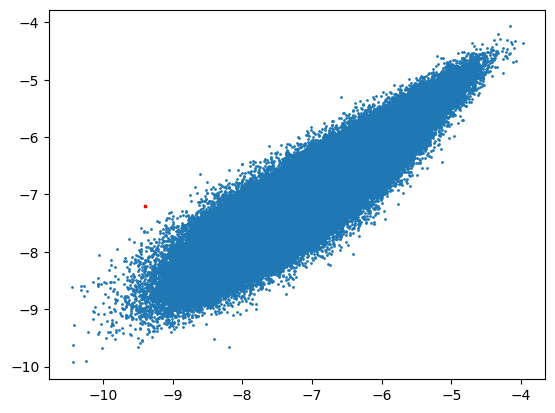

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(model.test_true_y, model.test_pred_y, s=1)
# 标记idx
plt.scatter(model.test_true_y[idx], model.test_pred_y[idx], s=3, c='r')

In [13]:
# 787707993,57991841,1362042489
for d in data.train_dataset[idx.tolist()]:
    print(d.id, d.y)

tensor([562412253]) tensor([[-10.7270,  -9.8310,  -0.5340,   3.1350,   3.4980]])


In [4]:

data.setup(stage='test')
for batch in data.test_dataloader():
    p, x = model.model.forward_(batch)
    break


In [19]:

molecule_pre = list()
molecule_end = list()
atoms = list()
for i in range(128):
    molecule_pre.append(batch.pos[batch.batch==i].detach().numpy())
    molecule_end.append(x[batch.batch==i].detach().numpy())
    atoms.append(batch.x[batch.batch==i].detach().numpy())

In [7]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.axes import Axes
import numpy as np
from torch import Tensor
matplotlib.use('Qt5Agg')


In [40]:
elements_dict = {0: 'C', 1: 'H', 2: 'N', 3: 'O', 4: 'F', 5: 'S', 6: 'CL', 7: 'BR', 8: 'I', 9: 'P'}
# elements_dict = {'C': 0, 'H': 1, 'N': 2, 'O': 3, 'F': 4, 'S': 5, 'CL': 6, 'BR': 7, 'I': 8, 'P': 9}
fig = plt.figure()
fig: plt.Figure
ax = fig.add_subplot(projection='3d')
ax: Axes
t = 0
ax.scatter(molecule_pre[t][:,0], molecule_pre[t][:,1], molecule_pre[t][:,2], c='b')
# 加入分子的id
molecules = batch.id.tolist()
ax.text2D(0.05, 0.95, "Molecule ID: ZINC{}".format(str(molecules[t]+int(1e12))[1:]), transform=ax.transAxes)
print("Molecule ID: ZINC{}".format(str(molecules[t]+int(1e12))[1:]))
ax.scatter(molecule_end[t][:,0], molecule_end[t][:,1], molecule_end[t][:,2], c='r')
for i in range(molecule_pre[t].shape[0]):
    ax.text(molecule_pre[t][i,0], molecule_pre[t][i,1], molecule_pre[t][i,2], elements_dict[atoms[t][i]], 'x')
for i in range(molecule_end[t].shape[0]):
    ax.plot([molecule_pre[t][i,0], molecule_end[t][i,0]], [molecule_pre[t][i,1], molecule_end[t][i,1]], [molecule_pre[t][i,2], molecule_end[t][i,2]], c='g')
# 将对应的两个点连起来
plt.show()

Molecule ID: ZINC001528757027


In [22]:
molecule_pre[t][:,0]
atoms[t]

array([2, 1, 0, 2, 1, 3, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0], dtype=int64)

In [32]:
%matplotlib

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = np.arange(0, 10, 0.1)
x = x.reshape(2, -1)
y = np.sin(x)
z = np.cos(x)
ax.plot(x, y)
plt.show()

Using matplotlib backend: Qt5Agg


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (100,)  and requested shape (2,)